On the use of Half-Wave Plate demodulation
====

Nowadays, most experiments or future experiments plan to use a HWP to modulate the incoming polarisation.
This has several advantages, such as a reduction of instrument systematics contamination. Let's imagine we are scanning the sky with our instrument an our HWP. The resulting timestream model is

$$d = I + Q \cos(2\theta_{par} + 4\theta_{HWP}) + U \sin(2\theta_{par} + 4\theta_{HWP})$$

where I dropped explicit time dependency. $\theta_{par}$ is the parallactic angle (pointing) $\theta_{HWP}$ is the HWP angle. and Once you have your timestreams, and potentially injected your instrument effects, you would like to estimate I, Q and U. Here you have two methods: pair differencing and hwp demodulation.

** Pair differencing **

This is what was used so far. The idea is to combine two bolometers from the same pair, having orthogonal polarisation:

$$\begin{align}
d_{top} &= I + Q \cos(2\theta_{par} + 4\theta_{HWP}) + U \sin(2\theta_{par} + 4\theta_{HWP}) \\
d_{bottom} &= I - Q \cos(2\theta_{par} + 4\theta_{HWP}) - U \sin(2\theta_{par} + 4\theta_{HWP})
\end{align}$$

Adding or subtracting them let have access to temperature or polarisation respectively:

$$\begin{align}
d_{+} &= \dfrac{d_{top} + d_{bottom}}{2} = I \\
d_{-} &= \dfrac{d_{top} - d_{bottom}}{2} = Q \cos(2\theta_{par} + 4\theta_{HWP}) + U \sin(2\theta_{par} + 4\theta_{HWP}) 
\end{align}$$

** HWP demodulation **

In the pair differencing scheme, you need two bolometers with orthogonal polarisation to estimate I, Q, and U. The HWP demodulation is working differently. You capitalise on the fact that I and Q&U have not the same dependency on the HWP rotation angle. Let's rewrite our timestream model a bit differently:

$$\begin{align}
d &= I + Q \cos(2\theta_{par} + 4\theta_{HWP}) + U \sin(2\theta_{par} + 4\theta_{HWP}) \\
  &= I + \cal{Re}\big[ (Q + iU) e^{-2i\theta_{par} - 4i\theta_{HWP}} \big]
\end{align}$$

then, the temperature and the polarisation part of the timstream can be extracted using a set of low pass and band pass filters:

$$\begin{align}
d^0 &= \cal{LPF}(d) = I \\
d^4 &= \cal{LBPF}(2d \times e^{2i\theta_{par} + 4i\theta_{HWP}}) = Q + iU
\end{align}$$

With this formalism, one extracts I, Q, and U directly from a single timestream.

** Caveats **

Each formalism (pair difference and hwp demodulation) has its pros and cons. One of the biggest cons of the hwp demodulation is that for the method to be accurate (because of the filters that are applied to the timestreams), you need:

$$ f_{\rm{detector\, sampling}} >> f_{\rm{hwp\, spin\, frequency}} $$

In practice, a factor of 10 or more is requested, which means that you need more memory available. Also, note that the fact that timestreams are convoluted with filters slow down the computation with respect to the pair difference technique.

** Reference **

I based my implementation on a recent paper: https://arxiv.org/abs/1702.07111

In [1]:
## Import basic modules and routines
from __future__ import division, absolute_import, print_function

## In case you did not install properly the library 
## or didn't update your bashrc. (Do it later!)
import os
path_to_s4cmb = '../../s4cmb'
os.sys.path.insert(0, os.path.realpath(path_to_s4cmb))

import healpy as hp
import pylab as pl
import numpy as np

## Import modules and routines from s4cmb
from s4cmb.input_sky import HealpixFitsMap

from s4cmb.instrument import Hardware

from s4cmb.scanning_strategy import ScanningStrategy

from s4cmb.tod import TimeOrderedDataPairDiff
from s4cmb.tod import TimeOrderedDataDemod
from s4cmb.tod import OutputSkyMap
from s4cmb.tod import partial2full

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

Initialise our instrument, scanning strategy and input maps as seen in the Day 1 lectures.
However, in line with what has been said previously about the accuracy of the HWP demodulation technique, we will increase the sampling of the detectors to 24 Hz >> 1 Hz for the HWP.

In [7]:
## Instrument
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., fwhm=3.5, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_hwp='CRHWP', freq_hwp=1., angle_hwp=0., verbose=False)

## Input maps
nside = 512
path_to_cls = '../../s4cmb/s4cmb/data/test_data_set_lensedCls.dat'
sky_in = HealpixFitsMap(path_to_cls, do_pol=True, 
                        fwhm_in=inst.beam_model.fwhm, nside_in=nside, 
                        map_seed=5843787, verbose=False, 
                        no_ileak=False, no_quleak=False)

## Scanning strategy
scan = ScanningStrategy(nces=1, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=24., sky_speed=0.4,
                        ut1utc_fn='../../s4cmb/s4cmb/data/ut1utc.ephem', 
                        language='fortran')
scan.run()

In [8]:
## Loop over scans
for CESnumber in range(scan.nces):
    ## Note that we specify that we want to map pairs
    ## one-by-one by setting mapping_perpair to True. This is 
    ## very useful if you have no det-to-det correlations and 
    ## you want to save memory by ot storing all timestreams
    ## in the memory.
    tod_demod = TimeOrderedDataDemod(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        mapping_perpair=True)
    
    ## Just for visualisation we also compute the result with Pair Diff
    tod_diff = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        mapping_perpair=True)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky_demod = OutputSkyMap(
            projection=tod_demod.projection, 
            nside=tod_demod.nside_out, 
            obspix=tod_demod.obspix,
            demodulation=True)
        
        sky_diff = OutputSkyMap(
            projection=tod_diff.projection, 
            nside=tod_diff.nside_out, 
            obspix=tod_diff.obspix,
            demodulation=False)
        
    ## Scan input map to get TODs
    ## Do it pair-by-pair to save memory for large runs.
    for pair in tqdm(tod_demod.pair_list):
        ## Demodulated TS
        d_demod = np.array([tod_demod.map2tod(det) for det in pair])
        d_demod = tod_demod.demodulate_timestreams(d_demod)
        tod_demod.tod2map(d_demod, sky_demod)
        
        ## Pair diff
        d_diff = np.array([tod_diff.map2tod(det) for det in pair])
        tod_diff.tod2map(d_diff, sky_diff)

100%|██████████| 64/64 [01:31<00:00,  1.27s/it]


Let's have a look at the different part of timestreams:

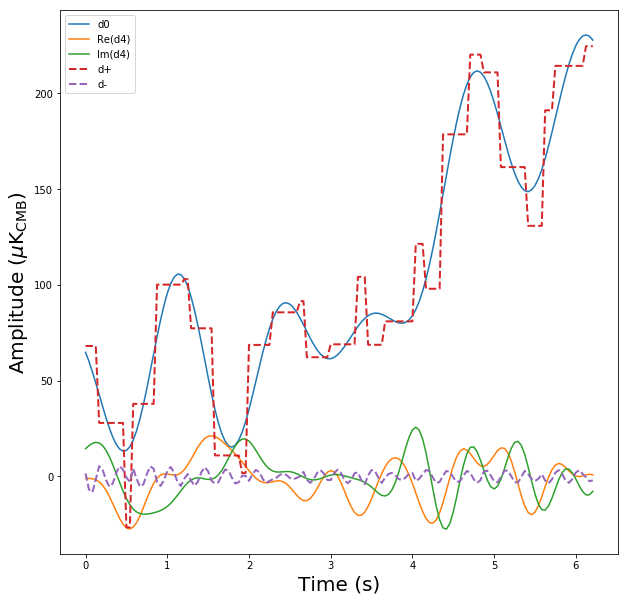

In [9]:
bolo=0
stop=150

fig = pl.figure(figsize=(10, 10))

xaxis = [t/scan.sampling_freq for t in range(0, stop)]

## Demodulation
pl.plot(xaxis, d_demod[bolo][0][0:stop], label='d0')
pl.plot(xaxis, d_demod[bolo][1][0:stop], label='Re(d4)')
pl.plot(xaxis, d_demod[bolo][2][0:stop], label='Im(d4)')

## Pair difference
pl.plot(
    xaxis, 
    (d_diff[bolo][0:stop] + d_diff[bolo+1][0:stop])/2, 
    ls='--', label='d+', lw=2)
pl.plot(
    xaxis, 
    (d_diff[bolo][0:stop] - d_diff[bolo+1][0:stop])/2, 
    ls='--', label='d-', lw=2)

pl.legend()
pl.xlabel('Time (s)', fontsize=20)
pl.ylabel('Amplitude ($\mu$K$_{\\rm CMB}$)', fontsize=20)
pl.show()

You notice that $d^0$ (see definition above) is a smoothed version of $d^+$ (in this example numbers are naive! One should use a higher freq sampling). $d^4$ and $d^-$ differ from cos and sin.

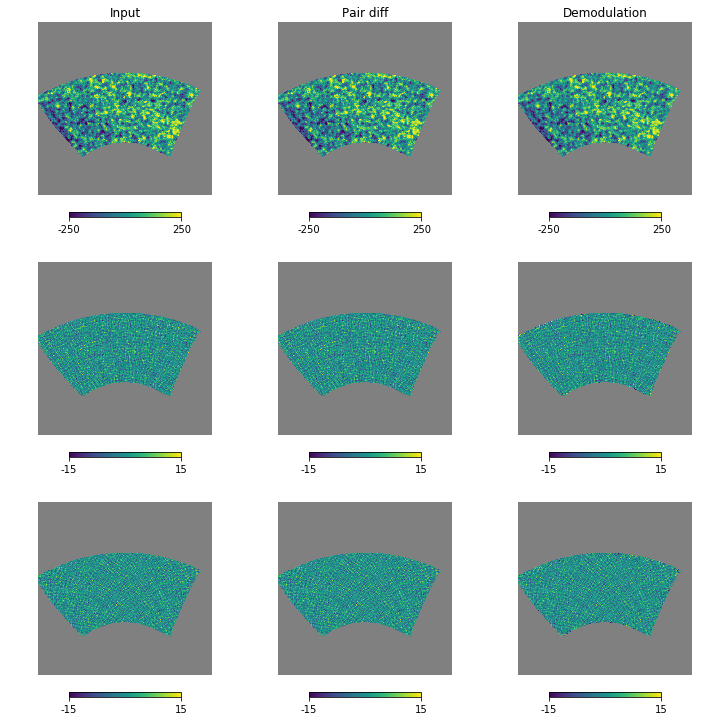

In [11]:
xsize = 500
fig = pl.figure(figsize=(10, 10))

nhit_diff = partial2full(
    sky_diff.nhit, 
    sky_diff.obspix, 
    sky_diff.nside, fill_with=0.0)

nhit_demod = partial2full(
    sky_demod.nhit, 
    sky_demod.obspix, 
    sky_demod.nside, fill_with=0.0)

## Temperature
sky_diff_I = partial2full(
    sky_diff.get_I(), 
    sky_diff.obspix, 
    sky_diff.nside, fill_with=0.0)
sky_demod_I = partial2full(
    sky_demod.get_I(), 
    sky_demod.obspix, 
    sky_demod.nside, fill_with=0.0)

mask_diff = nhit_diff < 1
mask_demod = nhit_demod < 1
# sky_in.I[mask] = np.nan
sky_input = sky_in.I + 0.0
sky_input[mask_diff] = np.nan
sky_diff_I[mask_diff] = np.nan
sky_demod_I[mask_demod] = np.nan
hp.gnomview(sky_input, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=331, 
            title='Input', notext=True, min=-250, max=250)
hp.gnomview(sky_diff_I, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=332, 
            title='Pair diff', notext=True, min=-250, max=250)
hp.gnomview(sky_demod_I, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=333, 
            title='Demodulation', notext=True, min=-250, max=250)

## Stokes Q
sky_diff_Q = partial2full(
    sky_diff.get_QU()[0], 
    sky_diff.obspix, 
    sky_diff.nside, fill_with=0.0)
sky_demod_Q = partial2full(
    sky_demod.get_QU()[0], 
    sky_demod.obspix, 
    sky_demod.nside, fill_with=0.0)

mask_diff = nhit_diff < 10
mask_demod = nhit_demod < 10
sky_input = sky_in.Q + 0.0
sky_input[mask_diff] = np.nan
sky_diff_Q[mask_diff] = np.nan
sky_demod_Q[mask_demod] = np.nan

hp.gnomview(sky_input, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=334, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_diff_Q, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=335,  
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_demod_Q, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=336, 
            notext=True, title='', min=-15, max=15)

## Stokes Q
sky_diff_U = partial2full(
    sky_diff.get_QU()[1], 
    sky_diff.obspix, 
    sky_diff.nside, fill_with=0.0)
sky_demod_U = partial2full(
    sky_demod.get_QU()[1], 
    sky_demod.obspix, 
    sky_demod.nside, fill_with=0.0)

mask_diff = nhit_diff < 10
mask_demod = nhit_demod < 10
sky_input = sky_in.U + 0.0
sky_input[mask_diff] = np.nan
sky_diff_U[mask_diff] = np.nan
sky_demod_U[mask_demod] = np.nan

hp.gnomview(sky_input, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=337, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_diff_U, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=338,  
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_demod_U, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=339, 
            notext=True, title='', min=-15, max=15)

pl.show()

Great!